## Load Libs

In [3]:
%reload_ext autoreload
%autoreload 2

!pip install seaborn --upgrade

import os, sys, numpy as np, pandas as pd, tensorflow as tf, cv2
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from matplotlib import pyplot as plt
sns.set(style="white")

%matplotlib inline

def heatmap(data, *cols, target, xtick=None, ytick=None, annot=True, fmt='.2f', figsize=None):
    import seaborn as sns
    from matplotlib import pyplot as plt

    figsize = figsize or (16, 4)
    f, axs = plt.subplots(1, 2, figsize=figsize)

    def draw(chop, axis):
        pivot_params = list(cols) + [target]
        g = chop.groupby(list(cols))[target]
        mean_ = g.mean().reset_index().pivot(*pivot_params)
        count_ = g.size().reset_index().pivot(*pivot_params)
        if xtick is not None or ytick is not None:
            mean_ = mean_.reindex(index=ytick, columns=xtick)
            count_ = count_.reindex(index=ytick, columns=xtick)

        sns.heatmap(mean_.fillna(0), annot=annot, ax=axis[0], fmt=fmt, cmap="YlGnBu")
        sns.heatmap(count_.fillna(0), annot=annot, ax=axis[1], fmt=fmt, cmap="YlGnBu")
        axis[0].set_title('mean')
        axis[1].set_title('count')

    draw(data, axs)
    plt.show()
    
    
def chi_square(x, y, data, verbose=True):
    """
    Return: True if x is dependet with y else False
    """
    table = data.groupby([x, y]).size().reset_index(name='size')
    pivot = table.pivot(index=x, columns=y, values='size').fillna(0.)
    
    # Calculate chi-square value, p-value, degree of freedom, expected value
    chi, pv, df, expected = stats.chi2_contingency(observed=pivot.values)
    # check if chi-square value > criterion(95% confidence interval)
    crit = stats.chi2.ppf(q=0.95, df=df)
    if verbose:
        print(pivot)
        print()
        print(expected)
        print()
        print(f'chi-square value: {chi}, criterion: {crit}')
    return chi > crit

Requirement already up-to-date: seaborn in d:\python\anaconda3-5.2.0\envs\py3_6\lib\site-packages (0.9.0)


You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Purpose: 
* 給定電信客戶Metadata, 繳費行為等等, 預測該客戶是否在未來有可能離開?


## Data Schema

Column name         | Description
				 ---|---
customerIDCustomer 	|	ID

---
* 2個類別變數
* 84個數值變數
---
<br/>
<br/>
<br/>

# EDA(Exploratory Data Analysis)


---



In [11]:
raw = pd.read_csv("https://storage.googleapis.com/allianz-course/data/raw_tr_financial_distress.csv")
raw.head()

,Company,Time,distress_num,x1,x2,x3,x4,x5,x6,x7,...,x75,x76,x77,x78,x79,x80,x81,x82,x83,distress_catg
0,1,1,0.010636,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49,0
1,1,2,-0.455970,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50,0
2,1,3,-0.325390,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51,0
3,1,4,-0.566570,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52,1
4,2,1,1.357300,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27,0


In [12]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 87 columns):
Company          2557 non-null int64
Time             2557 non-null int64
distress_num     2557 non-null float64
x1               2557 non-null float64
x2               2557 non-null float64
x3               2557 non-null float64
x4               2557 non-null float64
x5               2557 non-null float64
x6               2557 non-null float64
x7               2557 non-null float64
x8               2557 non-null float64
x9               2557 non-null float64
x10              2557 non-null float64
x11              2557 non-null float64
x12              2557 non-null float64
x13              2557 non-null float64
x14              2557 non-null float64
x15              2557 non-null float64
x16              2557 non-null float64
x17              2557 non-null float64
x18              2557 non-null float64
x19              2557 non-null float64
x20              2557 non-null float64


## Observe the label distribution

In [15]:
2504 / 53

47.24528301886792

0    2504
1      53
Name: distress_catg, dtype: int64



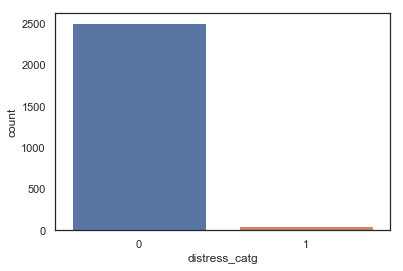

In [17]:
print( raw.distress_catg.value_counts() )
print()
sns.countplot(x='distress_catg', data=raw)

## Observation

* Not Churn : Churn 的數量大約是 1 : 47 左右, 是所謂imbalanced dataset

---

<br/>
<br/>
<br/>

# 多變數分析: Categorical x Categorical

* heatmap: 也可個別觀察單變數與Label之間的關係
---



## 類別變數的 Correlation Heatmap

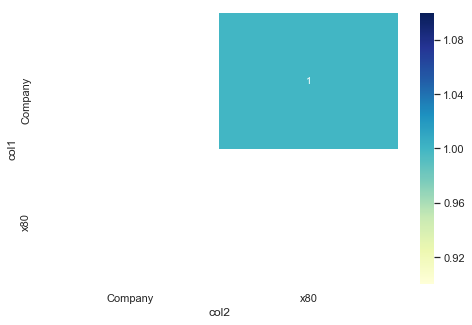

In [21]:
catg_features = ['Company', 'x80']
num_features = [f'x{i}' for i in range(1, 84) if i != 80]

def catg_corr(catg_cols, data):
    corr = []
    for i, x in enumerate(catg_cols):
        corr += [(x, x, 1)]
        for y in catg_cols[i+1:]:
            r = int(chi_square(x, y, data, verbose=False))
            corr += [(x, y, r), (y, x, r)]
            
    corr = pd.DataFrame(data=corr, columns=['col1', 'col2', 'val'])\
             .pivot('col1', 'col2', 'val')
    return corr

corr = catg_corr(catg_features, raw)
plt.figure(figsize=(8, 5))
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True
sns.heatmap(corr, cmap="YlGnBu", mask=mask, annot=True)

## Company x x80: Heatmap

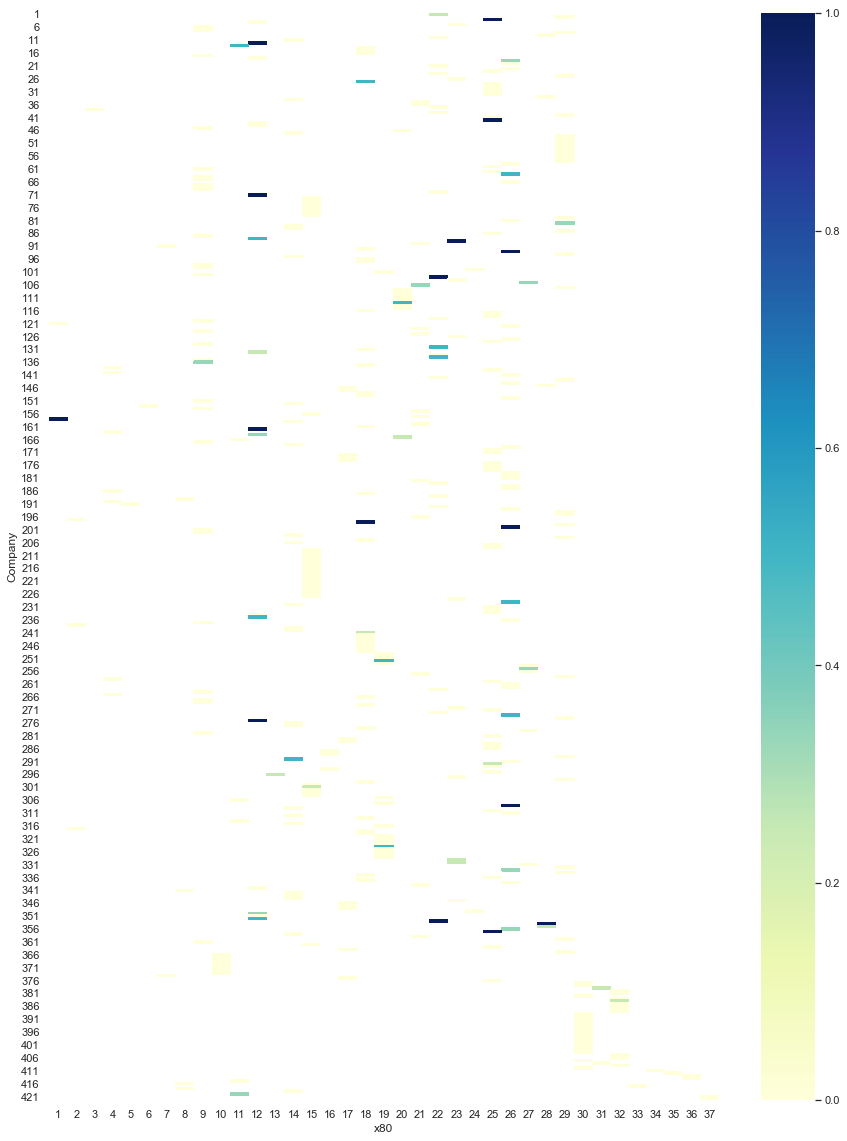

In [47]:
tmp = raw.groupby(['Company', 'x80']).distress_catg.mean().reset_index(name='values')
plt.figure(figsize=(15, 20))
sns.heatmap(tmp.pivot_table(index='Company', columns='x80', values='values'), cmap="YlGnBu")
plt.show()

<br/>
<br/>
<br/>

---

# 多變數分析: Categorical x Numeric


## x80 cross x1: Violin Plot, Distribute Plot
* 畫Countplot觀察數量分布

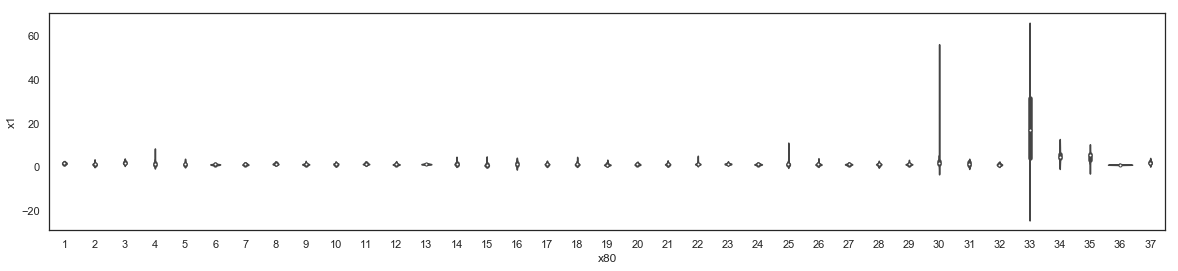

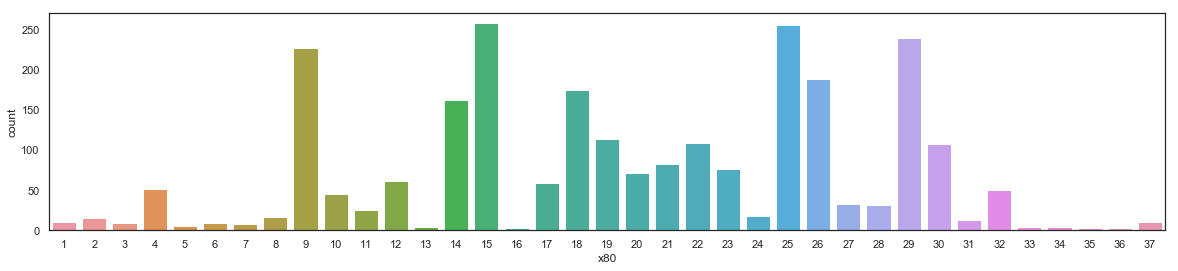

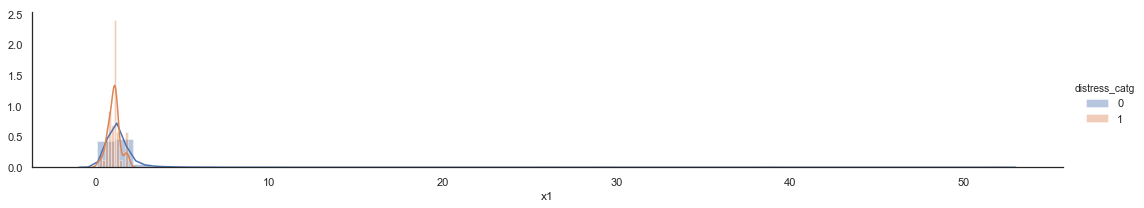

In [83]:
plt.figure(figsize=(20, 4))
ax = sns.violinplot(data=raw,
            x='x80',
            y='x1')
plt.show()

plt.figure(figsize=(20, 4))
ax = sns.countplot(data=raw, x='x80')
plt.show()

g = sns.FacetGrid(hue='distress_catg', data=raw, aspect=5)
g.map(sns.distplot, 'x1').add_legend()

## x80 cross x2: Violin Plot, Distribute Plot

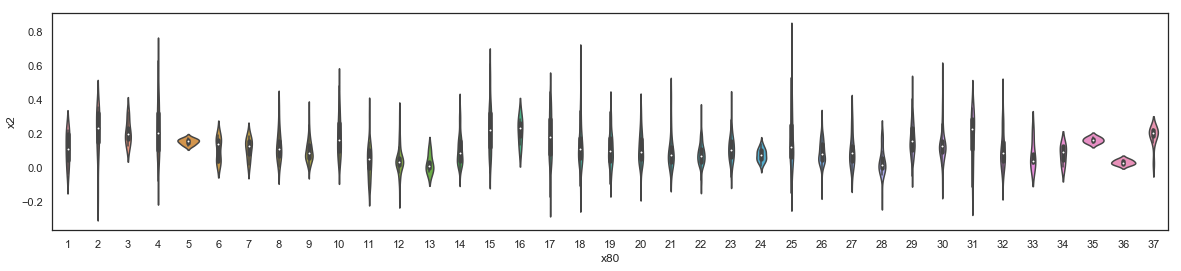

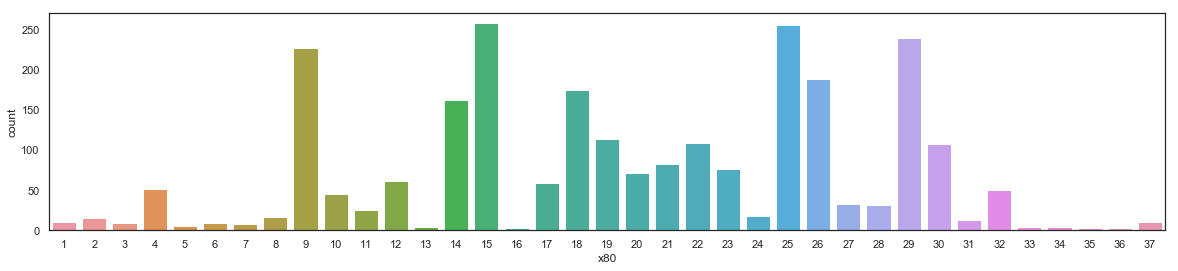

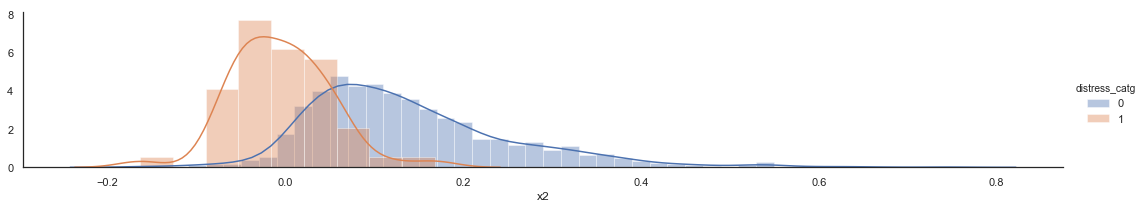

In [73]:
plt.figure(figsize=(20, 4))
ax = sns.violinplot(data=raw,
            x='x80',
            y='x2')
plt.show()

plt.figure(figsize=(20, 4))
ax = sns.countplot(data=raw, x='x80')
plt.show()

g = sns.FacetGrid(hue='distress_catg', data=raw, aspect=5)
g.map(sns.distplot, 'x2').add_legend()

## (LAB) x80 cross x3: 檢視`x80, x3`是否有關係, `x3` feature是否顯著
* Violin Plot, Countplot, Distribute Plot

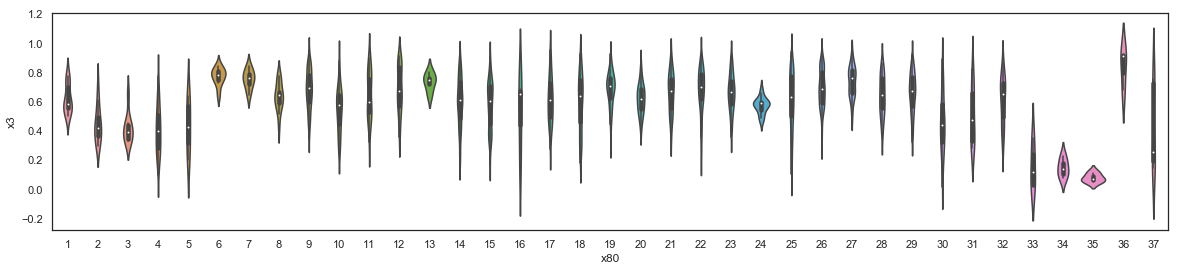

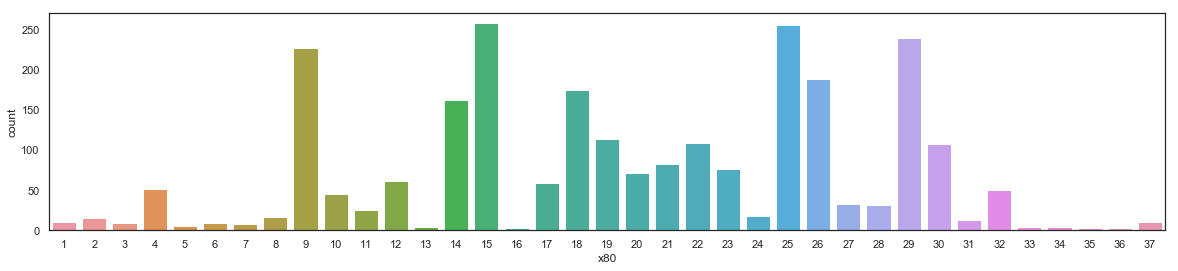

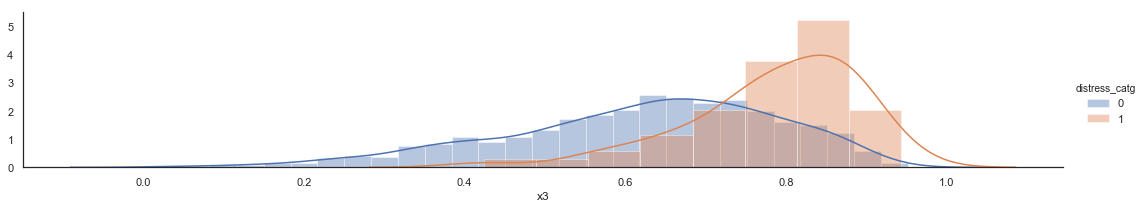

In [81]:
plt.figure(figsize=(20, 4))
ax = sns.violinplot(data=raw,
            x='x80',
            y='x3')
plt.show()

plt.figure(figsize=(20, 4))
ax = sns.countplot(data=raw, x='x80')
plt.show()

g = sns.FacetGrid(hue='distress_catg', data=raw, aspect=5)
g.map(sns.distplot, 'x3').add_legend()

## (LAB) x80 cross x4: 檢視 x80, x4是否有關係, x4 feature是否顯著
* Violin Plot, Countplot, Distribute Plot

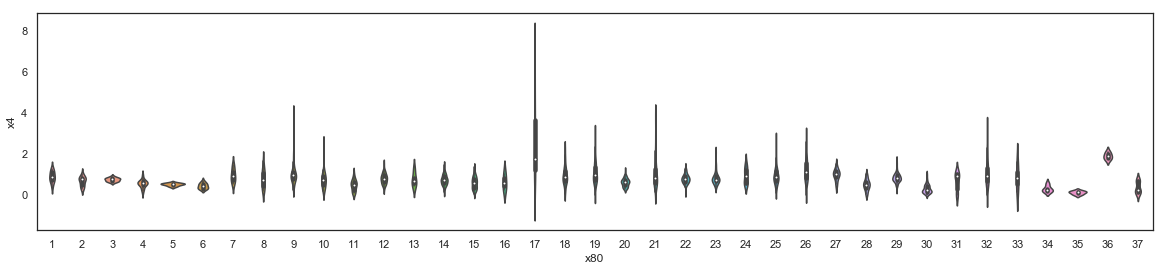

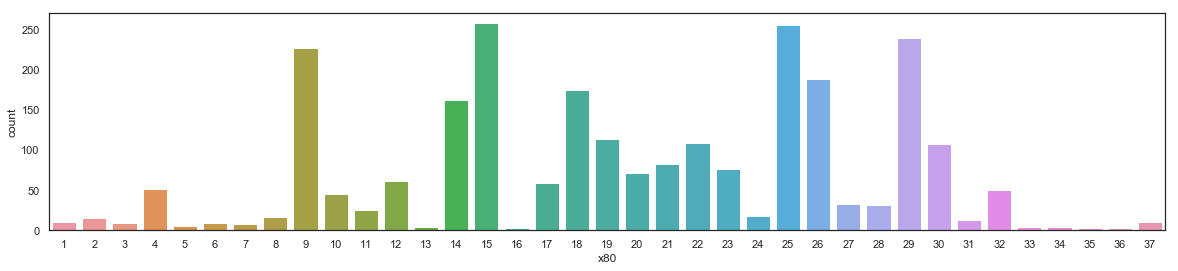

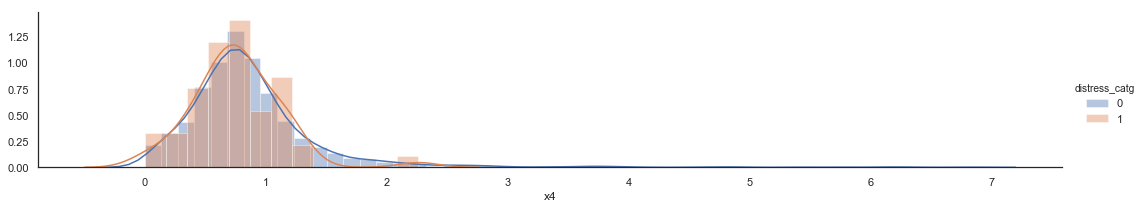

In [82]:
plt.figure(figsize=(20, 4))
ax = sns.violinplot(data=raw,
            x='x80',
            y='x4')
plt.show()

# Start here: draw the Count plot ##############
plt.figure(figsize=(20, 4))
ax = sns.countplot(data=raw, x='x80')
plt.show()
# Stop here ##############

g = sns.FacetGrid(hue='distress_catg', data=raw, aspect=5)
g.map(sns.distplot, 'x4').add_legend()

## (LAB) 在 x10 ~ x79當中挑選出兩個, 檢視是否與 x80, 有關係, 且該Feature是否顯著

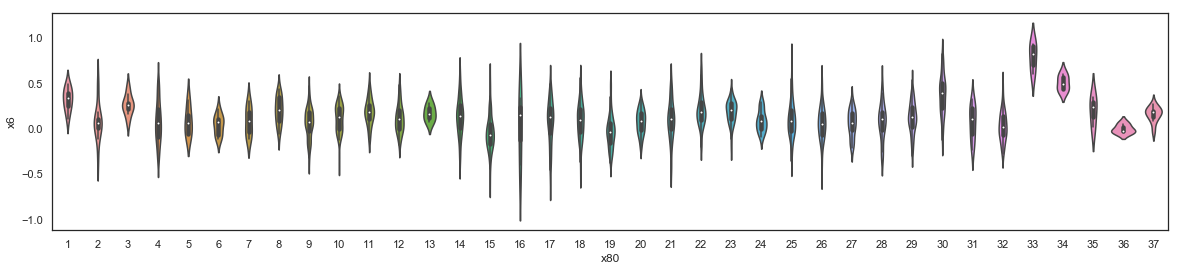

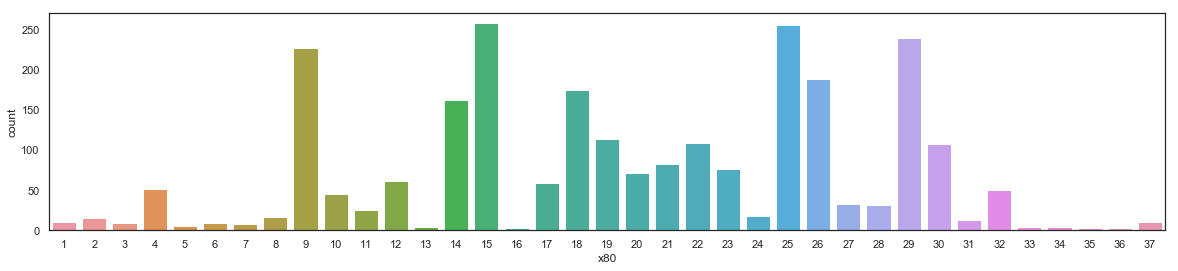

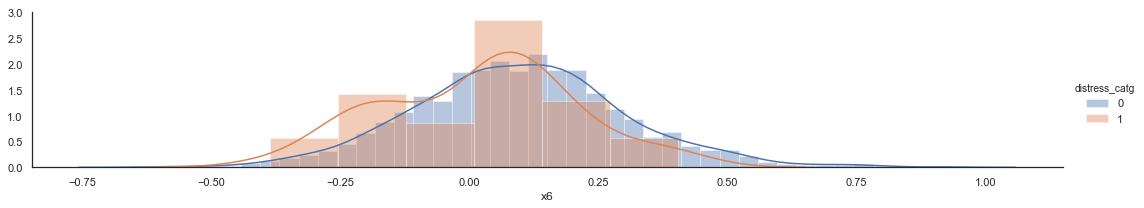

In [84]:
plt.figure(figsize=(20, 4))
ax = sns.violinplot(data=raw,
            x='x80',
            y='x6')
plt.show()

# Start here: draw the Count plot ##############
plt.figure(figsize=(20, 4))
ax = sns.countplot(data=raw, x='x80')
plt.show()
# Stop here ##############

g = sns.FacetGrid(hue='distress_catg', data=raw, aspect=5)
g.map(sns.distplot, 'x6').add_legend()

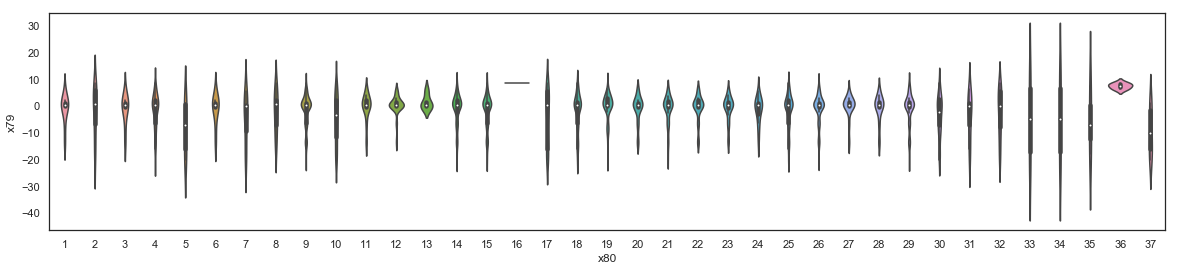

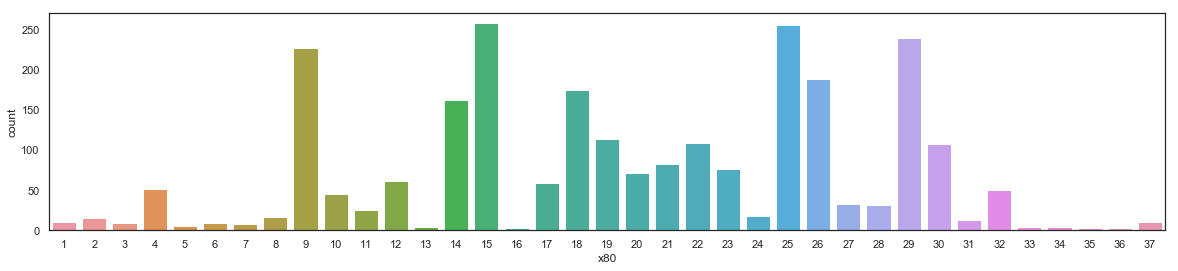

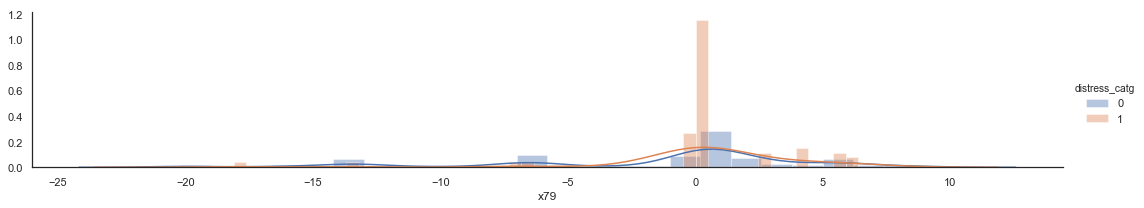

In [85]:
plt.figure(figsize=(20, 4))
ax = sns.violinplot(data=raw,
            x='x80',
            y='x79')
plt.show()

# Start here: draw the Count plot ##############
plt.figure(figsize=(20, 4))
ax = sns.countplot(data=raw, x='x80')
plt.show()
# Stop here ##############

g = sns.FacetGrid(hue='distress_catg', data=raw, aspect=5)
g.map(sns.distplot, 'x79').add_legend()

## Observation

* `x80, x2`: 有非線性關係, `x2`是顯著feature
* `x80, x3`: 有非線性關係, `x3`是顯著feature




---


# 多變數分析: Numeric x Numeric

## Correlation: Pearson, Spearman
- Pearson: 變數最好遵從常態分配, 介於 -1 ~ 1之間, 1線性正相關, -1: 線性負相關

$$ \rho = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})} {\sqrt{\sum(x_i - \bar{x})^2(y_i - \bar{y})^2}} $$

---

- Spearman: 只注重排序關係, numeric, ordinal變數都可以接受, 介於 -1 ~ 1之間, 1線性正相關, -1: 線性負相關

$$ \rho = 1 - \frac{6  \sum d_i^2} {n(n^2 - 1)} $$

- 這裡只看pearson相關係數

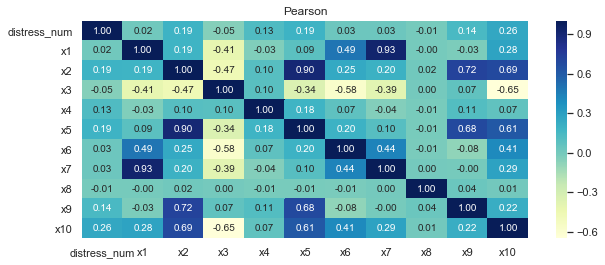

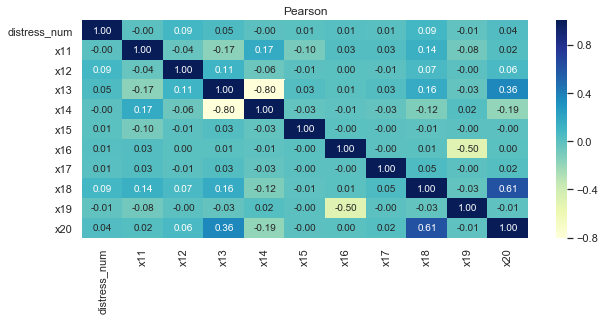

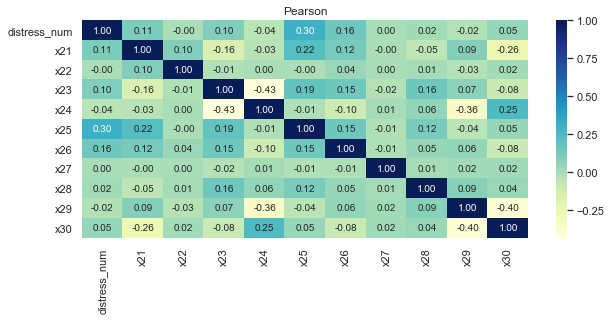

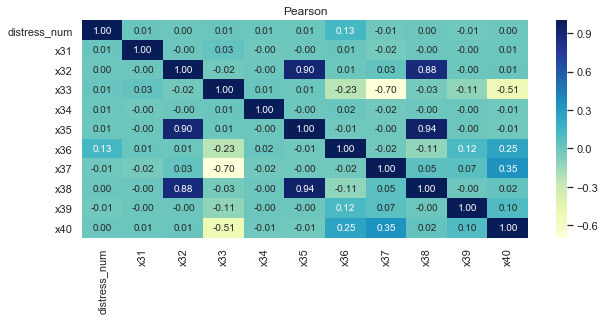

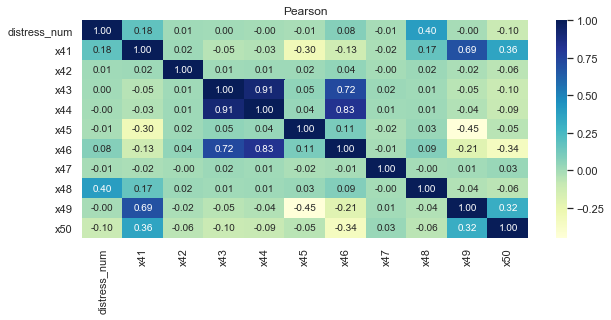

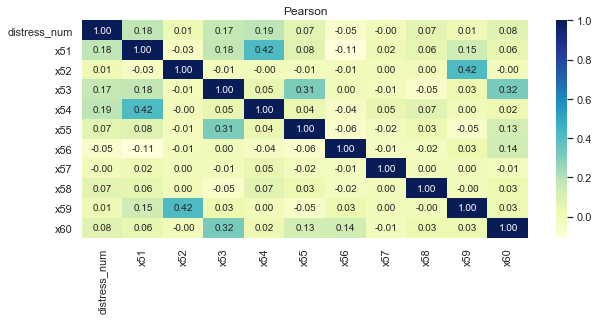

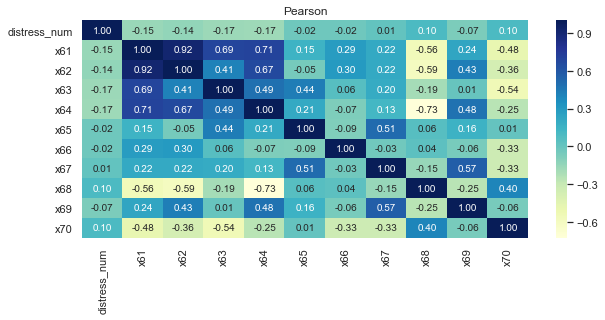

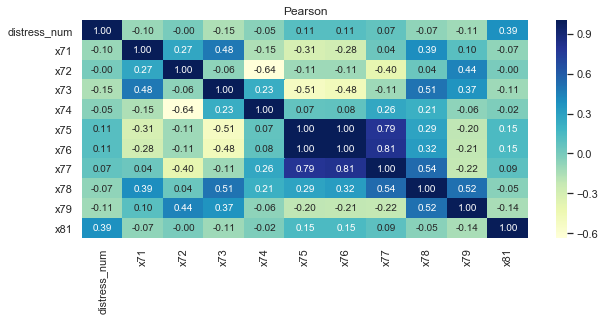

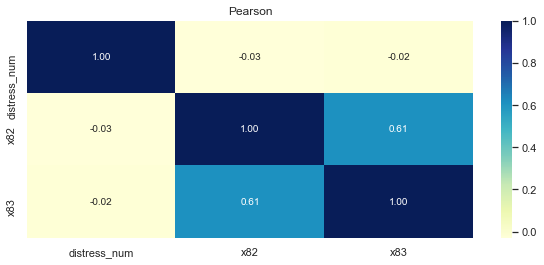

In [100]:
n_batch = 10
for cut_pos in np.arange(0, len(num_features), n_batch):
    plt.figure(figsize=(10, 4))
    batch_cols = ['distress_num'] + num_features[cut_pos:cut_pos + n_batch]
    sns.heatmap(raw[batch_cols].corr(), annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Pearson')
    plt.show()

In [103]:
corr = raw.corr()
corr['distress_num'][(corr['distress_num'] <= -0.3) | (corr['distress_num'] >= 0.3)]

distress_num    1.000000
x25             0.302677
x48             0.395974
x81             0.385780
Name: distress_num, dtype: float64

In [136]:

# (tmp['75%'] - tmp['25%']) / (tmp['max'] - tmp['min'])

6672.118458023513

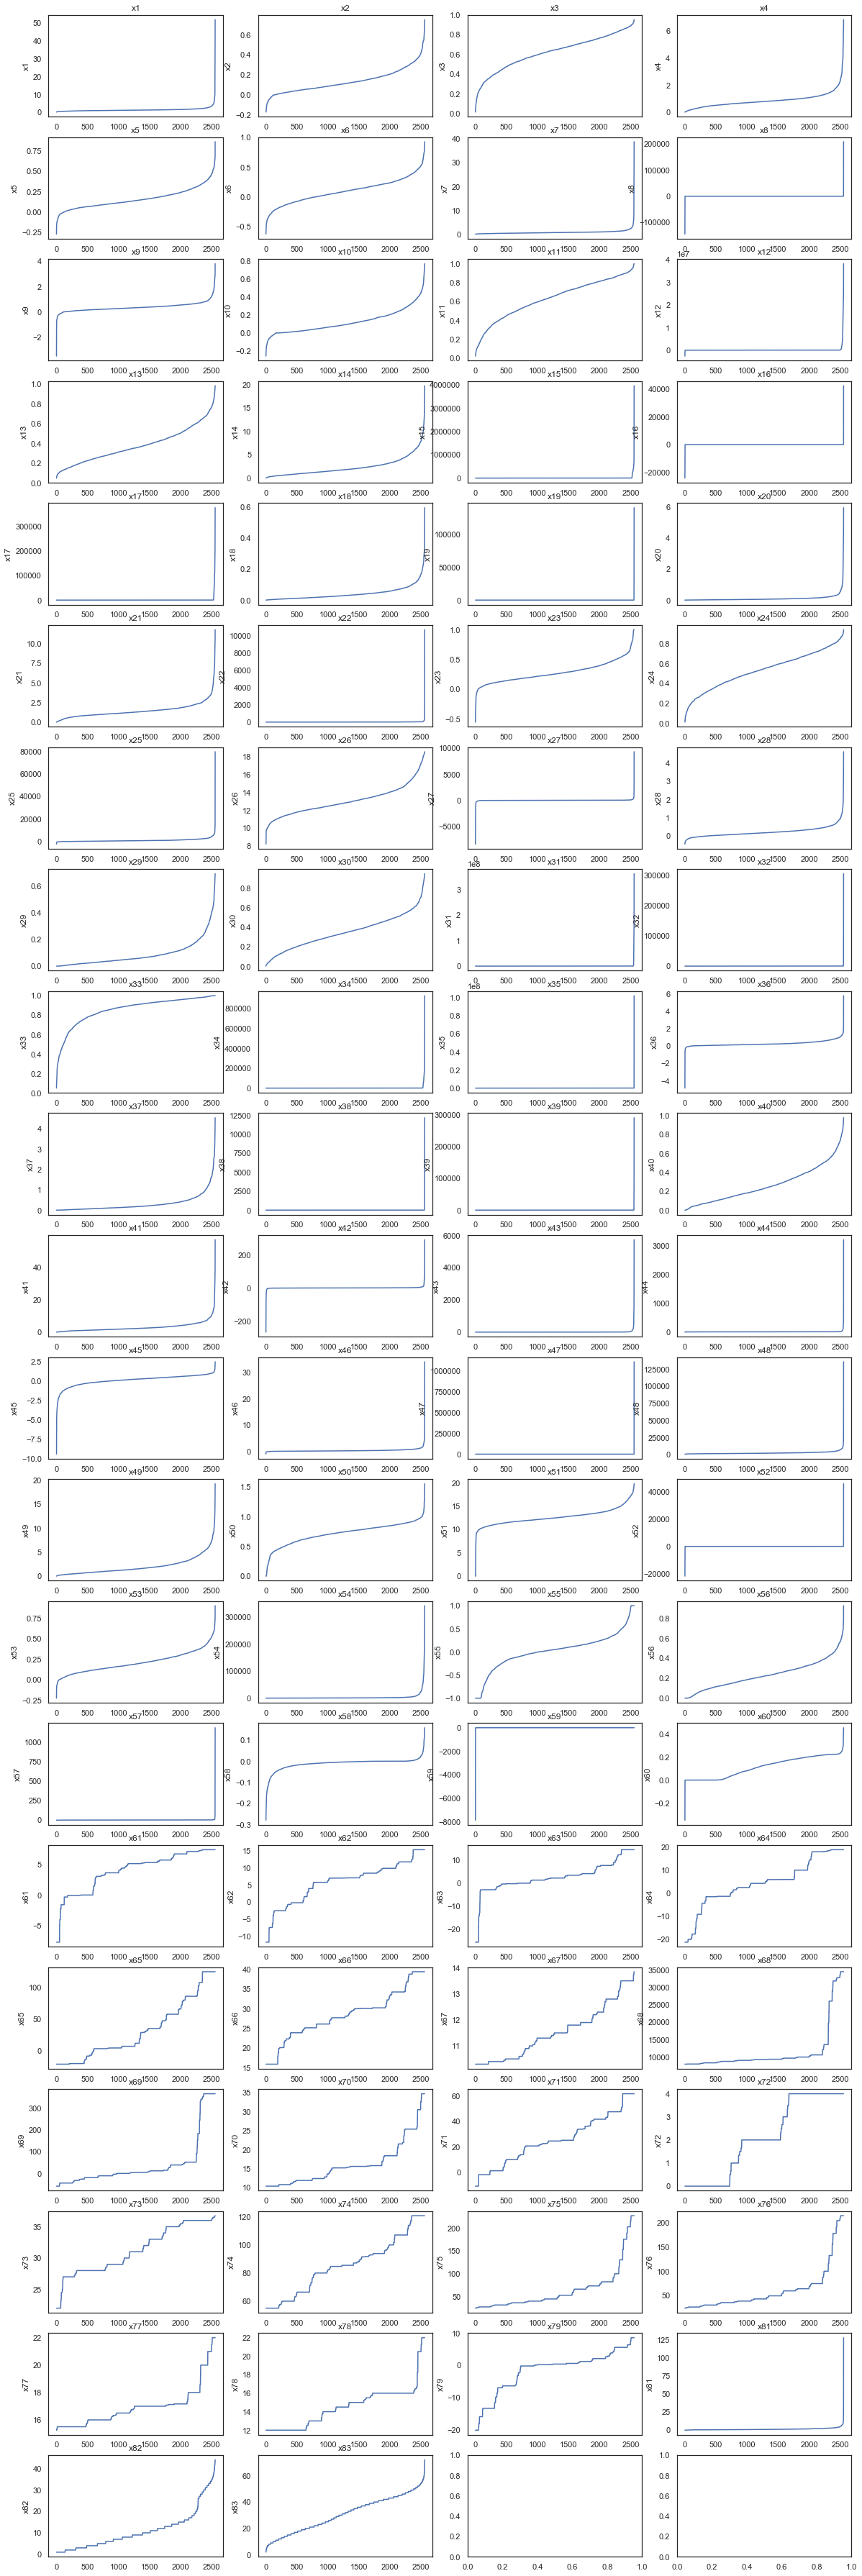

In [125]:
f, ax = plt.subplots(21, 4, figsize=(20, 65))
idx = np.arange(len(raw))

for col, axis in zip(num_features, ax.ravel()[:len(num_features)]):
    sns.lineplot(idx, raw[col].sort_values(), ax=axis)
    axis.set_title(col)
plt.show()

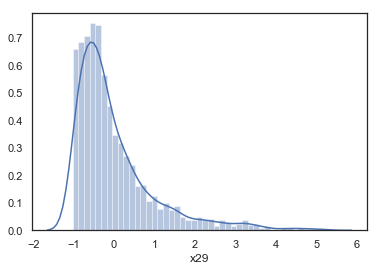

In [155]:
tmp = MinMaxScaler().fit_transform(raw[num_features])
tmp = np.log1p(tmp)
scaler = StandardScaler()
tmp = pd.DataFrame(data=scaler.fit_transform(tmp), columns=num_features)
sns.distplot(tmp.x29.sort_values())

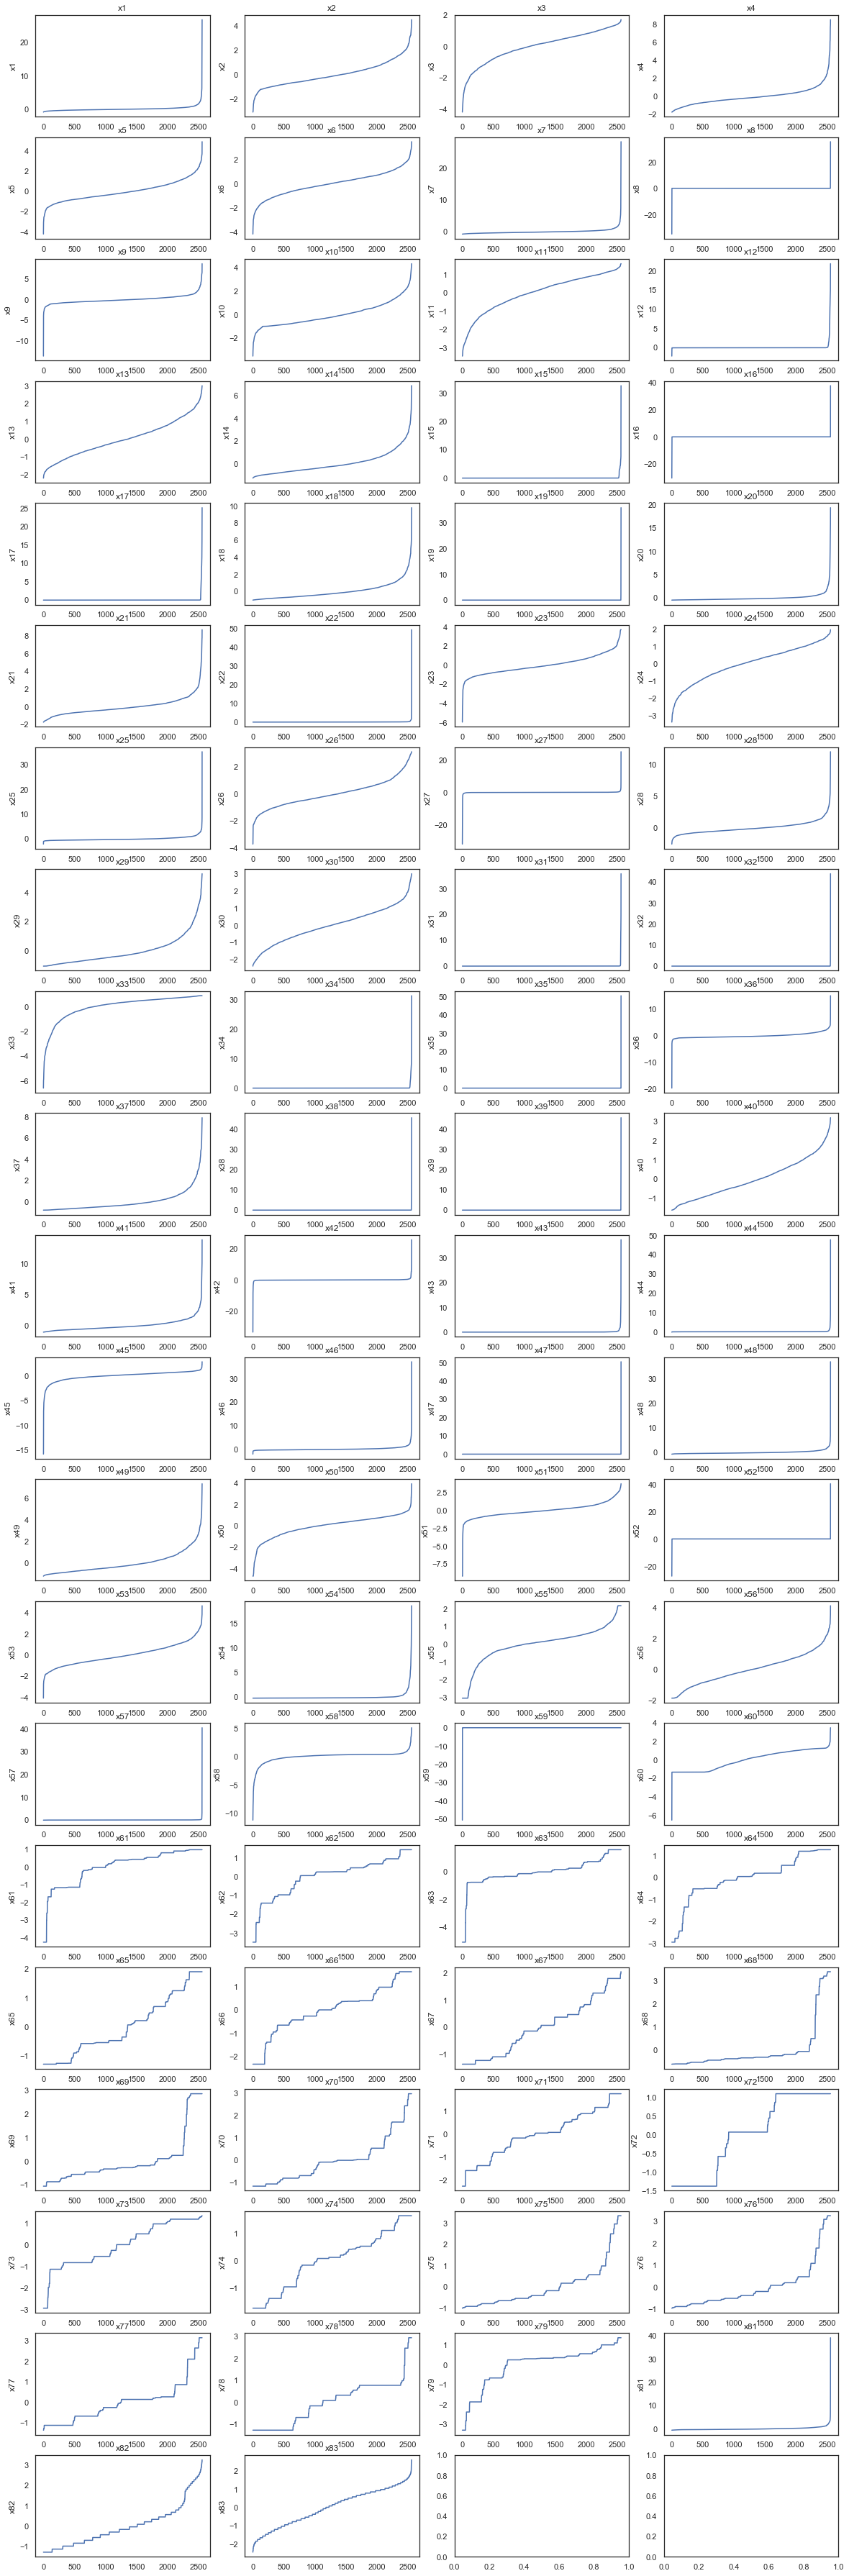

In [146]:
tmp = MinMaxScaler().fit_transform(raw[num_features])
tmp = np.log1p(tmp)
scaler = StandardScaler()
tmp = pd.DataFrame(data=scaler.fit_transform(tmp), columns=num_features)

f, ax = plt.subplots(21, 4, figsize=(20, 65))
idx = np.arange(len(tmp))
for col, axis in zip(num_features, ax.ravel()[:len(num_features)]):
    sns.lineplot(idx, tmp[col].sort_values(), ax=axis)
    axis.set_title(col)
plt.show()

##  TotalCharges x tenure: Regression Plot

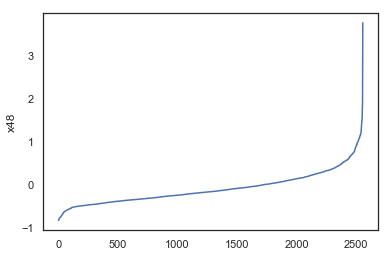

In [115]:
mean, std = raw.x48.mean(), raw.x48.std()
tmp = (raw.x48 - mean) / std
sns.lineplot(np.arange(len(raw)), np.log1p(tmp.sort_values()))

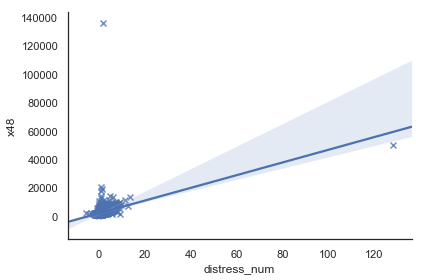

In [107]:
g = sns.lmplot(x='distress_num', y='x48',
               data=raw, height=4, aspect=1.5, markers='x')

##  MonthlyCharges x tenure: Regression Plot

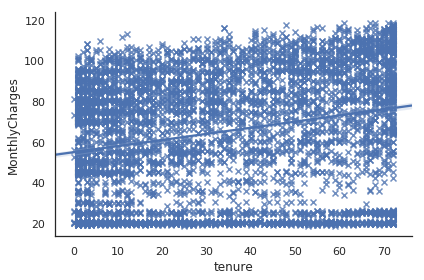

In [5]:
g = sns.lmplot(x='tenure', y='MonthlyCharges',
               data=raw_telco, height=4, aspect=1.5, markers='x')

## MonthlyCharges x TotalCharges: Regression Plot

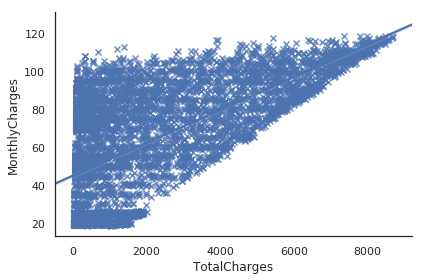

In [6]:
g = sns.lmplot(x='TotalCharges', y='MonthlyCharges',
               data=raw_telco, height=4, aspect=1.5, markers='x')

### 觀察一下為什麼`Tenure` `TotalCharges` `MonthlyCharges`有高度線性正向關係

In [0]:
raw_telco[['MonthlyCharges', 'tenure', 'TotalCharges']].head()

,MonthlyCharges,tenure,TotalCharges
0,29.85,1,29.85
1,56.95,34,1889.50
2,53.85,2,108.15
3,42.30,45,1840.75
4,70.70,2,151.65


### Observation

* `TotalCharges` 近似於  `MonthlyCharges` * `Tenure` 
* **理當來說應該是要完全一致的數字, 但是卻有偏差, 有可能是資料float差異, 或是其它因素**


### 新增`charges_diff`欄位

In [8]:
raw_telco['charges_diff'] = np.abs(raw_telco.MonthlyCharges * raw_telco.tenure - raw_telco.TotalCharges)
raw_telco[['MonthlyCharges', 'tenure', 'TotalCharges', 'charges_diff']].head()

,MonthlyCharges,tenure,TotalCharges,charges_diff
0,29.85,1,29.85,0.00
1,56.95,34,1889.50,46.80
2,53.85,2,108.15,0.45
3,42.30,45,1840.75,62.75
4,70.70,2,151.65,10.25


count    5634.000000
mean       47.236812
std        75.316467
min         0.000000
25%         9.300000
50%        28.550000
75%        63.237500
max      1385.300000
Name: charges_diff, dtype: float64


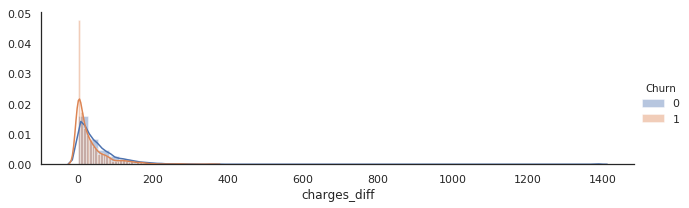

In [29]:
print( raw_telco.charges_diff.describe() )
g = sns.FacetGrid(data=raw_telco, hue='Churn', height=3, aspect=3)
g.map(sns.distplot, 'charges_diff').add_legend()

# sns.catplot(x='Churn', y='charges_diff', data=raw_telco, kind='violin')
# plt.show()

## Observation

* 新增的欄位 `charges_diff` 對於Churn並沒有顯著不同的分布


---

<br/>
<br/>
<br/>

# Conclusion

* 顯著變數
    - Numeric
        - tenure
        - MonthlyCharges

    - Categorical
        - SeniorCitizen
        - Contract
        - PaymentMethod
        - PaperlessBilling
        - Partner
        - Dependents
        - MultipleLines
        - OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, InternetService
        
        
* 變數相關性
    - `tenure, MonthlyCharges` 與 `TotalCharges` 正相關
    - `InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies` 非線性相關
    - 其餘參考 Chi Square Correlation Table, 和 Pearson Correlation Table

In [0]:
# catg_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
#        'PhoneService', 'MultipleLines', 'InternetService',
#        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
#        'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
#        'PaymentMethod', 'Churn']

# num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# tmp = raw_telco.drop(['customerID'], 1)
# corr = tmp.apply(lambda x: x if x.name in num_features else pd.factorize(x)[0]).corr()

# plt.figure(figsize=(12, 6))
# ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
#                  linewidths=.2, cmap="YlGnBu")